# THE TILTED FLOOT ISN'T WORKING IN SIM SO MUST BE WRONG FOR ESTIMATION TOO!!!

* Build trajectory from the rosbag
* Get the angle of the ramp
* Load the scene with the angled ramp
* Play the trajectory

* Segment the trajectory in sliding sections into a data struct for regression

* Run regression on the friction coefficient

* Perform trajectory optimization with the friction coefficient

(optional) see if you can add the arm planning as well (as a final position and velocity = start of the box traj)

In [1]:
using Revise
using Bilevel
using Bilevel: VariableSelector, ConstraintSelector, add_var!, add_eq!, add_ineq!, contact_jacobian!, contact_friction_τ_direct!, contact_normal_τ_direct!

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using ForwardDiff
using Base.Threads

using RobotOSData
using FileIO
using Dates
using Plots
using Rotations
using Statistics
using DSP

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007f84293045eb, Ptr{Nothing} @0x00007f84292d5204, P

In [2]:
bag = load("/home/blandry/Downloads/2019-05-25-11-02-05.bag")
pose_data = bag["/conductor/vrpn_client/kimtech_box/pose"]

# downsample
pose_data = pose_data[1:5:end];

In [3]:
N = length(pose_data)

qtraj = Array{Array{Float64,1},1}()
ttraj = Array{Float64,1}()

rot = RotX(pi/2)
x0 = 0.
y0 = 0.

ranges = [[1,N]]
ranges = [[310,330]]

for i = 1:length(ranges)
    first = ranges[i][1]
    last = ranges[i][2]
    for n = first:last
        if n == first
            t = 0.
        else
            t1 = pose_data[n-1].data.header.time
            t2 = pose_data[n].data.header.time
            dt1 = DateTime(unix2datetime(t1.secs) + Nanosecond(t1.nsecs))
            dt2 = DateTime(unix2datetime(t2.secs) + Nanosecond(t2.nsecs))
            h = (dt2 - dt1).value ./ 1000.
            t = ttraj[end] + h
        end

        x = pose_data[n].data.pose.position.x
        y = pose_data[n].data.pose.position.y
        z = pose_data[n].data.pose.position.z
        qw = pose_data[n].data.pose.orientation.w
        qx = pose_data[n].data.pose.orientation.x
        qy = pose_data[n].data.pose.orientation.y
        qz = pose_data[n].data.pose.orientation.z

        pos = [x,y,z]
        quat = Quat(qw,qx,qy,qz)

        pos_rot = rot * pos
        quat_rot = vcat(qw, rot * [qx, qy, qz])

        if n == first
            x0 = pos_rot[1]
            y0 = pos_rot[2]
        end    
        pos_rot = pos_rot - [x0,y0,0.]

        q = vcat(quat_rot, pos_rot)

        push!(qtraj, q)
        push!(ttraj, t)
    end
end

In [ ]:
z = [q[5] for q in qtraj]
plot(z)

In [4]:
urdf = joinpath("..", "..", "urdf", "small_box.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.125)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [0.0, 0.0, 0.0], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false))])

In [5]:
# getting the ramp angle

world_frame = default_frame(root_body(mechanism))
box_frame = default_frame(findbody(mechanism, "box"))
box_normal = Point3D(box_frame, SVector([0.,0.,1.]...))

q0 = qtraj[1]
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
ramp_normal = transform(x0, box_normal, world_frame)

a = [0.,0.,1.]
b = ramp_normal.v
axis = cross(a, b)
angle = acos(a'*b/(norm(a)*norm(b)))

aa = AngleAxis(angle, axis[1], axis[2], axis[3])

RotXYZ(aa)

3×3 RotXYZ{Float64}(-0.245984, 0.0118291, 0.00146228):
  0.999929    -0.00146218  0.0118288
 -0.00146218   0.969901    0.243494 
 -0.0118288   -0.243494    0.96983  

In [ ]:
q0

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
IJuliaCell(mvis)

In [ ]:
setanimation!(mvis, ttraj, qtraj)

In [6]:
xtraj = [q[5] for q in qtraj]'
ytraj = [q[6] for q in qtraj]'
ztraj = [q[7] for q in qtraj]'
htraj = [ttraj[i+1] - ttraj[i] for i = 1:length(ttraj)-1]'
vtraj = vcat(diff(xtraj,dims=2)./htraj,diff(ytraj,dims=2)./htraj,diff(ztraj,dims=2)./htraj)

3×20 Array{Float64,2}:
  0.0587881   0.0621855   0.0494457   0.0433505  …  0.000214577  -0.000309944
  0.415661    0.378216    0.346801    0.328474      0.000335276   0.00038296 
 -0.13498    -0.150487   -0.109629   -0.0967827     0.000249594   0.000823662

In [7]:
for i = 1:size(vtraj,2)
    if (any(isinf.(vtraj[:,i])) || any(isnan.(vtraj[:,i])))
        vtraj[:,i] = vtraj[:,i-1] 
    end
end

In [ ]:
plot(vtraj[2,:])

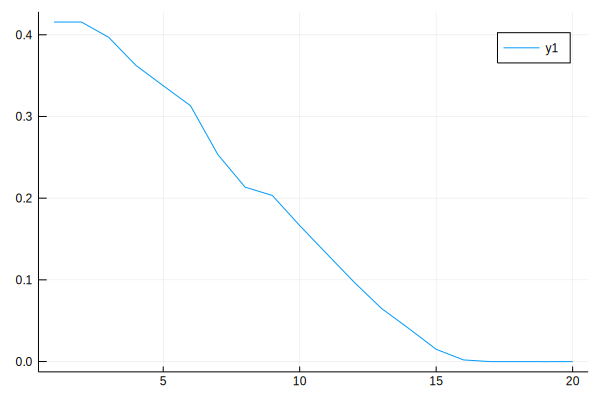

In [8]:
pad = 4
filter = digitalfilter(Lowpass(.1), FIRWindow(hanning(4)))

vtraj_filt_x = filt(filter, vcat(vtraj[1,1]*ones(pad),vtraj[1,:]))[pad+1:end]
vtraj_filt_y = filt(filter, vcat(vtraj[2,1]*ones(pad),vtraj[2,:]))[pad+1:end]
vtraj_filt_z = filt(filter, vcat(vtraj[3,1]*ones(pad),vtraj[3,:]))[pad+1:end]

vtraj_filt = vcat(vtraj_filt_x',vtraj_filt_y',vtraj_filt_z')

plot(vtraj_filt[2,:])

In [9]:
num_pos = num_positions(mechanism)
num_vel = num_velocities(mechanism)

sample_vs = VariableSelector()
add_var!(sample_vs, :q0, num_pos)
add_var!(sample_vs, :v0, num_vel)
add_var!(sample_vs, :u0, num_vel)
add_var!(sample_vs, :qnext, num_pos)
add_var!(sample_vs, :vnext, num_vel)
add_var!(sample_vs, :h, 1)

data = Array{Array{Float64,1},1}()

for n = 1:(length(qtraj)-2)
    q0 = qtraj[n]
    qnext = qtraj[n+1]
    u0 = zeros(num_vel) 
    
    h = htraj[n]
    
    v0 = vcat([0.,0.,0.],vtraj_filt[:,n])
    vnext = vcat([0.,0.,0.],vtraj_filt[:,n+1])
    
    sample = zeros(Float64, sample_vs.num_vars)
    sample[sample_vs(:q0)] = q0
    sample[sample_vs(:v0)] = v0
    sample[sample_vs(:u0)] = u0
    sample[sample_vs(:qnext)] = qnext
    sample[sample_vs(:vnext)] = vnext
    sample[sample_vs(:h)] = [h]
    
    push!(data, sample)
end

In [ ]:
data

In [123]:
vs = VariableSelector()
cs = ConstraintSelector()
add_var!(vs, :μ, 1)
add_ineq!(cs, :μ_pos, 1)

function generate_solver_fn_estimation_direct(data, sample_vs)    
    sim_data = get_sim_data_direct(mechanism,env,0.01)
    num_contacts = length(sim_data.env.contacts)
    num_vel = num_velocities(mechanism)
    num_samples = length(data)
    
    sim_data.normal_options[1]["num_fosteps"] = 0
    sim_data.normal_options[1]["num_sosteps"] = 0
    sim_data.normal_options[1]["c"] = 1
    sim_data.normal_options[1]["c_fos"] = 1
    sim_data.normal_options[1]["c_sos"] = 1

    sim_data.fric_options[1]["num_fosteps"] = 0
    sim_data.fric_options[1]["num_sosteps"] = 20
    sim_data.fric_options[1]["c"] = 1
    sim_data.fric_options[1]["c_fos"] = 1
    sim_data.fric_options[1]["c_sos"] = 1
    
    function eval_obj(params::AbstractArray{T}) where T
        # set the friction coefficient for the floor
        obstacles[1].μ = vs(params, :μ)[1]
        
        # evaluate the dynamics residual on each datapoint as an inner problem
        losses = zeros(T, num_samples)
        for i = 1:num_samples
            sample = data[i]
            q0 = sample_vs(sample, :q0)
            v0 = sample_vs(sample, :v0)
            u0 = sample_vs(sample, :u0)
            qnext = sample_vs(sample, :qnext)
            vnext = sample_vs(sample, :vnext)
            h = sample_vs(sample, :h)[1]

            x0 = sim_data.state_cache[1][Float64]
            xn = sim_data.state_cache[2][Float64]
            envj = sim_data.envj_cache[2][Float64]

            set_configuration!(x0, q0)
            set_velocity!(x0, v0)
            setdirty!(x0)
            set_configuration!(xn, qnext)
            set_velocity!(xn, vnext)
            setdirty!(xn)

            normalize_configuration!(x0)
            normalize_configuration!(xn)

            H = mass_matrix(x0)
            Hi = inv(H)
            config_derivative = configuration_derivative(xn)
            dyn_bias = dynamics_bias(xn)

            contact_jacobian!(envj, xn)
            normal_bias = Vector{T}(undef, num_vel)
            contact_bias = Vector{T}(undef, num_vel)
            
#             x_normal = contact_normal_τ_direct!(normal_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, params, 1)
            x_normal = [1.]
            
            contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, params, x_normal, 1)
        
            contact_bias_exp = u0 .- dyn_bias .- (1. / h) * H * (vnext - v0)
            
            # if (T<:ForwardDiff.Dual)
            #     display(map(ForwardDiff.value, map(ForwardDiff.value, contact_bias)))
            #     display(map(ForwardDiff.value, contact_bias_exp))
            # end
            
            err = contact_bias - contact_bias_exp
            loss = err'*err
            
            if !(isnan(loss) || isinf(loss))
                losses[i] = loss
#                 display(contact_bias)
#                 display(contact_bias_exp)
            end
        end
        
        # add losses
        sum(losses)
    end

    function eval_cons(params::AbstractArray{T}) where T        
        # friction coeffs are positive
        g = Vector{T}(undef, cs.num_eqs + cs.num_ineqs)
        μ = params[1]
        g[cs(:μ_pos)] .= [1e-6 - μ]
        
        g
    end
    
#     return eval_obj
    return Bilevel.generate_autodiff_solver_fn(eval_obj,eval_cons,cs.eqs,cs.ineqs,vs.num_vars,hessian=false)
end

solver_fn = generate_solver_fn_estimation_direct(data, sample_vs)

μ0 = [.1]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6
# options["Scale option"] = 2;

In [124]:
solver_fn([.07])

ForwardDiff.DualMismatchError{DataType,DataType}: Cannot determine ordering of Dual tags ForwardDiff.Tag{getfield(Bilevel, Symbol("#eval_cons_#24")){Array{Float64,1},Int64,Environment,VariableSelector,VariableSelector},Float64} and ForwardDiff.Tag{getfield(Main, Symbol("#eval_obj#55")){Array{Array{Float64,1},1},VariableSelector,SimData,Int64,Int64},Float64}

In [31]:
μopt, info = Bilevel.snopt(solver_fn, cs.num_eqs, cs.num_ineqs, μ0, options)

([0.0815953], "Terminated after numerical difficulties: current point cannot be improved")

# simulate to see

In [118]:
urdf = joinpath("..", "..", "urdf", "small_box.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector(qtraj[1][5:7]...))
normal = FreeVector3D(default_frame(floor), SVector(ramp_normal.v...))
floor_obs = Obstacle(floor, point, normal, :xyz, μopt[1])

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [0.0, 0.0, 0.0], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.688658], FreeVector3D in "after_floor_to_world": [0.0118288, 0.243494, 0.96983], [0.999929 -0.00146218 -0.999929 0.00146218; -0.00146218 0.969901 0.00146218 -0.969901; -0.0118288 -0.243494 0.0118288 0.243494], 0.0815953, false))])

In [78]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
IJuliaCell(mvis)

WebIO.Scope("scope-4004e599-80ac-4119-8c7d-9206577b2d5d", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :iframe), Any[], Dict{Symbol,Any}(:attributes=>Dict{String,Any}("height"=>"100%","scrolling"=>"no","src"=>"javascript:void(0)","frameborder"=>0),:id=>"ifr",:style=>Dict("width"=>"100%","flexGrow"=>"1")), 0)], Dict{Symbol,Any}(:style=>Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden")), 1), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}(), Set(String[]), nothing, Any[], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Ensure that the iframe's baseURI matches the baseURI of the\n    // outer document. This is necessary to resolve\n    // https://github.com/JuliaGizmos/WebIO.jl/issues/167\n    var base = doc.createElement(\"base\");\n    base.setAttribute(\"href\", document.baseURI);\n    doc.head.appendChild(base);\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/cff5eb7af79db7e6d407febf164549a9fdb258cd-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-687f8072-8e33-4c50-9f96-70cc2f88ea1b&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-687f8072-8e33-4c50-9f96-70cc2f88ea1b&quot;,&quot;id&quot;:&quot;ob_20&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); window.document.body.style.margin=&quot;0&quot;; return window.meshcat_viewer=this.viewer})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_19&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,184,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,102,108,111,111,114,47,98,111,120]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_21&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_20&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&quot;:{&quot;className&quot;:&quot;meshcat-viewer&quot;,&quot;style&quot;:{&quot;left&quot;:0,&quot;right&quot;:0,&quot;overflow&quot;:&quot;hidden&quot;,&quot;position&quot;:&quot;absolute&quot;,&quot;height&quot;:&quot;100vh&quot;,&quot;margin&quot;:0,&quot;width&quot;:&quot;100vw&quot;}},&q

In [119]:
N = 10
Δt = 0.1
q0 = qtraj[1]
v0 = vtraj_filt[:,5]

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[0.731685, -0.10893, 0.108949, 0.664004, 0.0, 0.0, 0.688658], [0.733409, -0.118988, 0.122263, 0.658032, 0.000963639, 0.0156903, 0.684707], [0.7349, -0.129009, 0.135539, 0.651849, 0.00288942, 0.0470713, 0.676804], [0.736159, -0.13899, 0.148775, 0.645459, 0.00577566, 0.0941431, 0.664951], [0.737184, -0.148929, 0.161966, 0.638863, 0.00962051, 0.156906, 0.649146], [0.737976, -0.158823, 0.175107, 0.632064, 0.014422, 0.235361, 0.62939], [0.738533, -0.168668, 0.188195, 0.625062, 0.0201779, 0.329508, 0.605682], [0.738856, -0.17846, 0.201225, 0.617861, 0.0268859, 0.439348, 0.578023], [0.738944, -0.188198, 0.214193, 0.610463, 0.0345435, 0.564882, 0.546412], [0.738797, -0.197877, 0.227095, 0.602869, 0.043148, 0.706109, 0.510849]], Array{Float64,1}[[0.0463981, 0.337638, -0.103206, 0.0, 0.0, 0.0], [0.0463981, 0.337638, -0.103206, 0.161156, 0.00753727, 0.0156393], [0.0463981, 0.337638, -0.103206, 0.320901, 0.0185803, 0.0420631], [0.0463981, 0.337638, -0.103206, 0.478635, 0.0331814,

In [121]:
setanimation!(mvis, traj[6], traj[1])

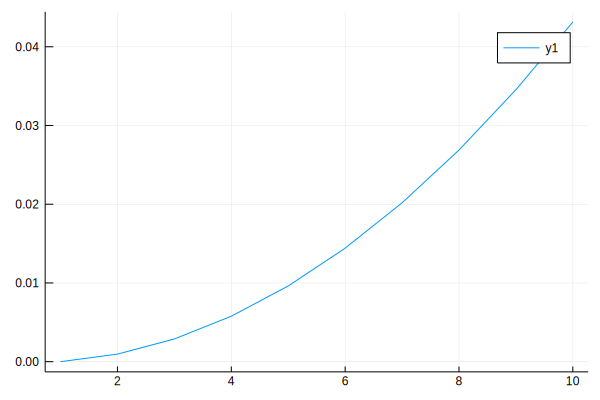

In [122]:
plot(traj[7][5,:])